# Comparison of losses

For a binary classification task we compare cross entropy loss to square error loss.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
plt.style.use("seaborn")

We load the fashion-MNIST dataset, a dataset of the same form and format as MNIST, only instead of handwritten digits it shows different types of clothing. The aim consists in identifying the type of clothing (shoe, T-shirt etc). See https://github.com/zalandoresearch/fashion-mnist

In [2]:
fashion = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # normalise so that all values in [0,1]

For a simpler example let's restrict the dataset to two classes, jumpers (class 2) and T-shirts (class 0)

In [3]:
x_bin_train=x_train[(y_train==0) | (y_train==2)]
y_bin_train=y_train[(y_train==0) | (y_train==2)]/2  # divide by 2, in order to get classes 0,1
x_bin_test=x_test[(y_test==0) | (y_test==2)]
y_bin_test=y_test[(y_test==0) | (y_test==2)]/2

We choose a simple neural network with two hidden layers, and a single output neuron with logistic activation

In [4]:
def get_model():
    model = tf.keras.models.Sequential([
      tf.keras.layers.Flatten(input_shape=(28, 28)),
      tf.keras.layers.Dense(80, activation='relu'),
      tf.keras.layers.Dense(40, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

We first pick cross entropy as loss function. In principle, we'd need to fine-tune the learning rate for SGD, but 0.05 seems fine enough. 

In [5]:
loss_fn = tf.keras.losses.BinaryCrossentropy()
model=get_model()
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.05),loss=loss_fn, metrics=['accuracy'])

Let's do the first fit. We record loss and metrics in the history object. In order to keep track of the test error we specify the test set as validation data.

In [6]:
history=model.fit(x_bin_train, y_bin_train, epochs=20,validation_data=(x_bin_test,y_bin_test))

Epoch 1/20
375/375 [==============================] - 1s 2ms/step - loss: 0.1540 - accuracy: 0.9515 - val_loss: 0.1160 - val_accuracy: 0.9625
Epoch 2/20
375/375 [==============================] - 1s 1ms/step - loss: 0.1095 - accuracy: 0.9653 - val_loss: 0.1126 - val_accuracy: 0.9660
Epoch 3/20
375/375 [==============================] - 1s 1ms/step - loss: 0.1011 - accuracy: 0.9668 - val_loss: 0.1024 - val_accuracy: 0.9610
Epoch 4/20
375/375 [==============================] - 1s 1ms/step - loss: 0.0917 - accuracy: 0.9695 - val_loss: 0.0959 - val_accuracy: 0.9695
Epoch 5/20
375/375 [==============================] - 0s 1ms/step - loss: 0.0871 - accuracy: 0.9714 - val_loss: 0.0943 - val_accuracy: 0.9720
Epoch 6/20
375/375 [==============================] - 1s 2ms/step - loss: 0.0828 - accuracy: 0.9719 - val_loss: 0.0969 - val_accuracy: 0.9705
Epoch 7/20
375/375 [==============================] - 1s 2ms/step - loss: 0.0785 - accuracy: 0.9734 - val_loss: 0.1021 - val_accuracy: 0.9640
Epoch 

Next, we pick mean square error as loss function. Again the learning rate would need to be fine-tuned carefully. I fiddled around a bit with it: larger learning rate leads to divergence, or at least worse accuracy. So, again a learning rate of 0.05 seems fine. 

In [7]:
loss_mse = tf.keras.losses.MeanSquaredError()
model=get_model()
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.05),loss=loss_mse, metrics=['accuracy'])
history_mse=model.fit(x_bin_train, y_bin_train, epochs=20,validation_data=(x_bin_test,y_bin_test))

Epoch 1/20
375/375 [==============================] - 1s 2ms/step - loss: 0.0472 - accuracy: 0.9503 - val_loss: 0.0365 - val_accuracy: 0.9580
Epoch 2/20
375/375 [==============================] - 1s 1ms/step - loss: 0.0320 - accuracy: 0.9615 - val_loss: 0.0326 - val_accuracy: 0.9605
Epoch 3/20
375/375 [==============================] - 0s 1ms/step - loss: 0.0292 - accuracy: 0.9657 - val_loss: 0.0346 - val_accuracy: 0.9540
Epoch 4/20
375/375 [==============================] - 1s 1ms/step - loss: 0.0276 - accuracy: 0.9668 - val_loss: 0.0306 - val_accuracy: 0.9635
Epoch 5/20
375/375 [==============================] - 1s 1ms/step - loss: 0.0264 - accuracy: 0.9697 - val_loss: 0.0295 - val_accuracy: 0.9635
Epoch 6/20
375/375 [==============================] - 1s 1ms/step - loss: 0.0255 - accuracy: 0.9707 - val_loss: 0.0275 - val_accuracy: 0.9670
Epoch 7/20
375/375 [==============================] - 1s 1ms/step - loss: 0.0245 - accuracy: 0.9711 - val_loss: 0.0285 - val_accuracy: 0.9645
Epoch 

Let's have a look at what data the history object contains:

In [8]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

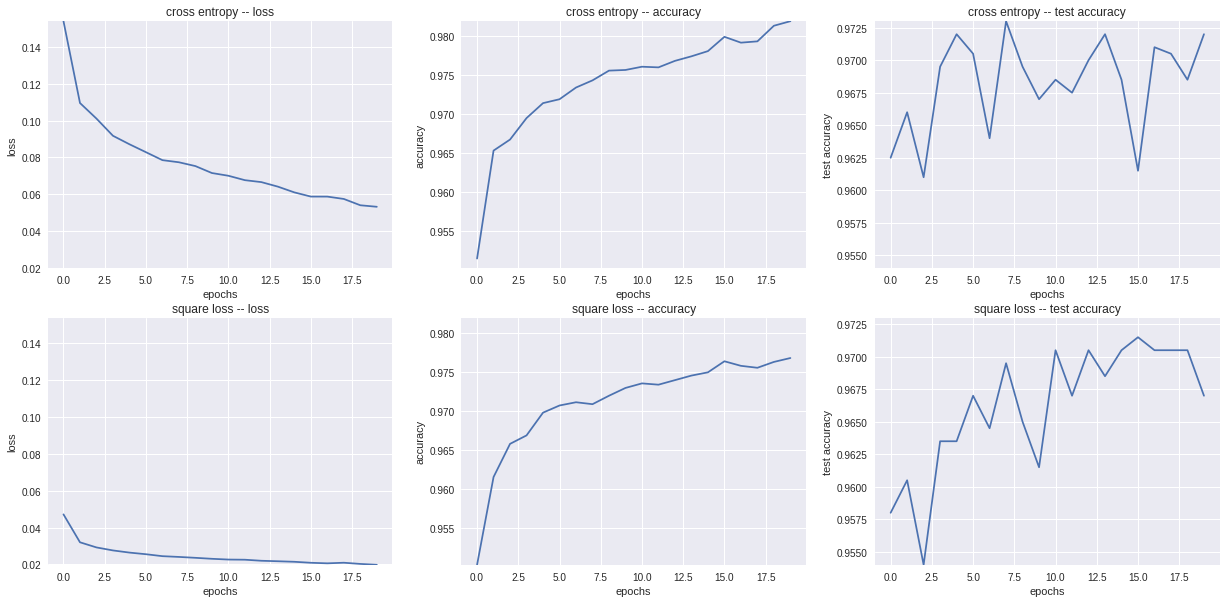

In [9]:
histories=[history,history_mse]
loss=["cross entropy","square loss"]
stat_names=['loss','accuracy','val_accuracy']
labels=['loss','accuracy', 'test accuracy']

lims={}
for stat in stat_names:
    m=min(min(history.history[stat]),min(history_mse.history[stat]))
    M=max(max(history.history[stat]),max(history_mse.history[stat]))
    lims[stat]=(m,M)
    
fig, axs = plt.subplots(2,3,figsize=(21,10))
for j in range(2):
    H=histories[j]
    for i,stat in zip(range(3),stat_names):
        axs[j,i].plot(H.history[stat])
        axs[j,i].set_title(loss[j]+" -- "+labels[i])
        axs[j,i].set_xlabel('epochs')
        axs[j,i].set_ylabel(labels[i])
        axs[j,i].set_ylim(*lims[stat])
plt.show()

Test accuracy seems too noisy for any insights. In the loss plot, however, we see that the curve for cross entropy loss decreases quite bit more quickly initially than for square error. The analogous behaviour can be seen in the (training) accuracy plot: the initial increase for cross entropy loss is slightly stronger than for square error. It should be noted, however, that we'd need to repeat this a couple of times, to make sure that these results are not statistical flukes. 